# Proyecto de pruebas A/B

# Descripci√≥n del ejercicio

Has recibido una tarea anal√≠tica de una tienda en l√≠nea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron. Solo dejaron las especificaciones t√©cnicas y los resultados de las pruebas.

## Descripci√≥n t√©cnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: –ê (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalizaci√≥n: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la regi√≥n de la UE
- Prop√≥sito de la prueba: probar cambios relacionados con la introducci√≥n de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 d√≠as posteriores a la inscripci√≥n, los usuarios mostrar√°n una mejor conversi√≥n en vistas de la p√°gina del producto (el evento `product_page`), instancias de agregar art√≠culos al carrito de compras (`product_cart`) y compras (`purchase`). En cada etapa del embudo `product_page ‚Üí product_cart ‚Üí purchase`, habr√° al menos un 10% de aumento.
- N√∫mero previsto de participantes de la prueba: 6 000

Contamos con 4 datasets donde se incluyen los datos de la prueba, comprueba si se ha realizado correctamente y analiza los resultados.

- `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en l√≠nea desde el 7 hasta el 21 de diciembre de 2020
- `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el per√≠odo comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

Estructura `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevar√° a cabo la campa√±a publicitaria
- `start_dt`: fecha de inicio de la campa√±a
- `finish_dt`: fecha de finalizaci√≥n de la campa√±a

Estructura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date`: fecha de inscripci√≥n
- `region`
- `device`: dispositivo utilizado para la inscripci√≥n

Estructura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

Estructura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenec√≠a el usuario

## Objetivos del estudio

- Verificar si la introducci√≥n del nuevo sistema de recomendaciones mejor√≥ la conversi√≥n en las etapas del embudo:
    - Vistas de la p√°gina del producto (product_page)
    - Agregar art√≠culos al carrito (product_card)
    - Compras realizadas (purchase)
- Comprobar si cada etapa muestra al menos un **10% de aumento en la conversi√≥n dentro de los 14 d√≠as posteriores al registro**.

## Exploraci√≥n de los datos

### Inicializaci√≥n

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm


In [2]:
# Cargamos los datasets
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
final_ab_new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
final_ab_events = pd.read_csv('final_ab_events_upd_us.csv')
final_ab_participants = pd.read_csv('final_ab_participants_upd_us.csv')

In [3]:
# Resumen inicial de los datos
def summarize_data(df, name):
    print(f"\n--- {name} ---")
    print(f"Filas y columnas: {df.shape}")
    print(f"Primeras filas:\n{df.head()}")
    print(f"Tipos de datos:\n{df.dtypes}")
    print(f"Valores duplicados: {df.duplicated().sum()}")
    print(f"Valores ausentes:\n{df.isnull().sum()}")

# a) Datos de Marketing
summarize_data(ab_project_marketing_events, 'Datos de Marketing')

# b) Datos de Usuarios Nuevos
summarize_data(final_ab_new_users, 'Usuarios Nuevos')

# c) Datos de Eventos
summarize_data(final_ab_events, 'Eventos')

# d) Datos de Participantes
summarize_data(final_ab_participants, 'Participantes')


--- Datos de Marketing ---
Filas y columnas: (14, 4)
Primeras filas:
                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
Tipos de datos:
name         object
regions      object
start_dt     object
finish_dt    object
dtype: object
Valores duplicados: 0
Valores ausentes:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

--- Usuarios Nuevos ---
Filas y columnas: (58703, 4)
Primeras filas:
            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       P

   - ¬øEs necesario convertir los tipos?
   - ¬øHay valores ausentes o duplicados? Si es as√≠, ¬øc√≥mo los caracterizar√≠as?

**Observaciones**

- La inspecci√≥n de datos nos indica que se encontraron valores ausentes en la columna **`details`** en el dataset 'Eventos'. Esto es normal ya que esa columna refleja el monto de compra para los eventos `purchase`. El resto de datasets no cuenta con valores ausentes.
- Ser√° necesario convertir las columnas de fechas al tipo 'datetime' ya que actualmente se catalogan como 'object'.

Ahora realizaremos la validaci√≥n espec√≠fica para cada archivo.


In [4]:
# a) Marketing: 
# Convertir columnas de fecha a datetime

ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

print("Tipos despu√©s de la conversi√≥n:")
print(ab_project_marketing_events.info())


Tipos despu√©s de la conversi√≥n:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None


In [5]:
# b) Usuarios Nuevos
# Convertir columnas de fecha a datetime
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

print("Tipos despu√©s de la conversi√≥n:")
print(final_ab_new_users.info())

Tipos despu√©s de la conversi√≥n:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


In [6]:
# Filtrar usuarios duplicados en user_id
duplicates_users = final_ab_new_users[final_ab_new_users.duplicated('user_id')]
if not duplicates_users.empty:
    print("\nUsuarios duplicados detectados en Usuarios Nuevos:")
    print(duplicates_users)
final_ab_new_users.drop_duplicates(subset='user_id', inplace=True)

# Filtrar solo usuarios de la regi√≥n EU
final_ab_new_users = final_ab_new_users[final_ab_new_users['region'] == 'EU']

# Filtrar usuarios fuera del rango de fechas del 7 al 21 de diciembre de 2020
final_ab_new_users = final_ab_new_users[
    (final_ab_new_users['first_date'] >= '2020-12-07') &
    (final_ab_new_users['first_date'] <= '2020-12-21') 
] 

print(final_ab_new_users.head())


            user_id first_date region   device
0  D72A72121175D8BE 2020-12-07     EU       PC
2  2E1BF1D4C37EA01F 2020-12-07     EU       PC
3  50734A22C0C63768 2020-12-07     EU   iPhone
7  8942E64218C9A1ED 2020-12-07     EU       PC
9  FFCEA1179C253104 2020-12-07     EU  Android


In [7]:
print(final_ab_new_users.info())

<class 'pandas.core.frame.DataFrame'>
Index: 39466 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     39466 non-null  object        
 1   first_date  39466 non-null  datetime64[ns]
 2   region      39466 non-null  object        
 3   device      39466 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB
None


In [8]:
# c) Eventos
# Convertir columnas de fecha a datetime
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

print("Tipos despu√©s de la conversi√≥n:")
print(final_ab_events.info())

Tipos despu√©s de la conversi√≥n:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None


In [9]:
# Filtrar eventos duplicados (user_id + event_dt)
duplicates_events = final_ab_events[final_ab_events.duplicated(['user_id', 'event_dt'])]
if not duplicates_events.empty:
    print("\nEventos duplicados detectados:")
    print(duplicates_events)
final_ab_events.drop_duplicates(subset=['user_id', 'event_dt'], inplace=True)

(final_ab_events.info())


Eventos duplicados detectados:
                 user_id            event_dt    event_name  details
60320   831887FE7F2D6CBA 2020-12-07 06:50:00  product_cart      NaN
60329   E2E76A8B3389127C 2020-12-07 15:39:00  product_cart      NaN
60338   649ECF69EC552A56 2020-12-07 06:19:00  product_cart      NaN
60343   435506A7A2265BBD 2020-12-07 11:53:00  product_cart      NaN
60346   909B249EB165910F 2020-12-07 07:06:00  product_cart      NaN
...                  ...                 ...           ...      ...
423754  D1553B56FFA8974B 2020-12-30 03:15:00         login      NaN
423755  6181F3835EBE66BF 2020-12-30 12:00:00         login      NaN
423756  245E85F65C358E08 2020-12-30 19:35:00         login      NaN
423759  F80C9BDDEA02E53C 2020-12-30 09:53:00         login      NaN
423760  7AEC61159B672CC5 2020-12-30 11:36:00         login      NaN

[238454 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 185307 entries, 0 to 423758
Data columns (total 4 columns):
 #   Column      Non

In [10]:
# Filtrar eventos fuera del rango de fechas
final_ab_events = final_ab_events[
    (final_ab_events['event_dt'] >= '2020-12-07') &
    (final_ab_events['event_dt'] <= '2021-01-01')
]

print(final_ab_events.info())

<class 'pandas.core.frame.DataFrame'>
Index: 185307 entries, 0 to 423758
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     185307 non-null  object        
 1   event_dt    185307 non-null  datetime64[ns]
 2   event_name  185307 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ MB
None


In [11]:
# d) Participantes
# Filtrar solo usuarios relacionados con la prueba 'recommender_system_test'
final_ab_participants = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']

# Verificar si alg√∫n usuario est√° en ambos grupos
cross_group_users = final_ab_participants.groupby('user_id')['group'].nunique()
cross_group_users = cross_group_users[cross_group_users > 1]
if not cross_group_users.empty:
    print("\nUsuarios presentes en ambos grupos detectados:")
    print(cross_group_users)
    # Eliminar estos usuarios
    final_ab_participants = final_ab_participants[~final_ab_participants['user_id'].isin(cross_group_users.index)]
    
print(final_ab_participants.head())
(final_ab_participants.info())

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB


**Observaciones**

- Realizamos la conversi√≥n de las columnas de fechas al tipo 'datetime'.
- Confirmamos que los datos en en dataset "Participantes" se limitan a la prueba 'recommender_system_test' y los grupos A y B.
- Verificamos que las regiones en el dataset "Nuevos Usuarios" sean exclusivamente UE.

## An√°lisis exploratorio


### Estudia la conversi√≥n en las diferentes etapas del embudo.


In [12]:
# Filtrar eventos clave
events_filtered = final_ab_events[final_ab_events['event_name'].isin(['product_page', 'product_cart', 'purchase'])]

# Combinar eventos con los participantes para asignar grupos
events_with_groups = events_filtered.merge(final_ab_participants, on='user_id', how='inner')

# Calcular eventos √∫nicos por grupo y etapa del embudo
conversion = events_with_groups.groupby(['group', 'event_name'])['user_id'].nunique().reset_index()
conversion = conversion.pivot(index='group', columns='event_name', values='user_id')

# Agregar c√°lculos de conversi√≥n en cada etapa
conversion['product_page_to_cart'] = conversion['product_cart'] / conversion['product_page']
conversion['cart_to_purchase'] = conversion['purchase'] / conversion['product_cart']

# Contar el total de usuarios √∫nicos por grupo
total_users_by_group = events_with_groups.groupby('group')['user_id'].nunique()
conversion['total_users'] = total_users_by_group

print("\nTasas de conversi√≥n por grupo:")
(conversion)



Tasas de conversi√≥n por grupo:


event_name  product_cart  product_page  purchase  product_page_to_cart  \
group                                                                    
A                    576           850       872              0.677647   
B                    184           278       256              0.661871   

event_name  cart_to_purchase  total_users  
group                                      
A                   1.513889         2235  
B                   1.391304          700

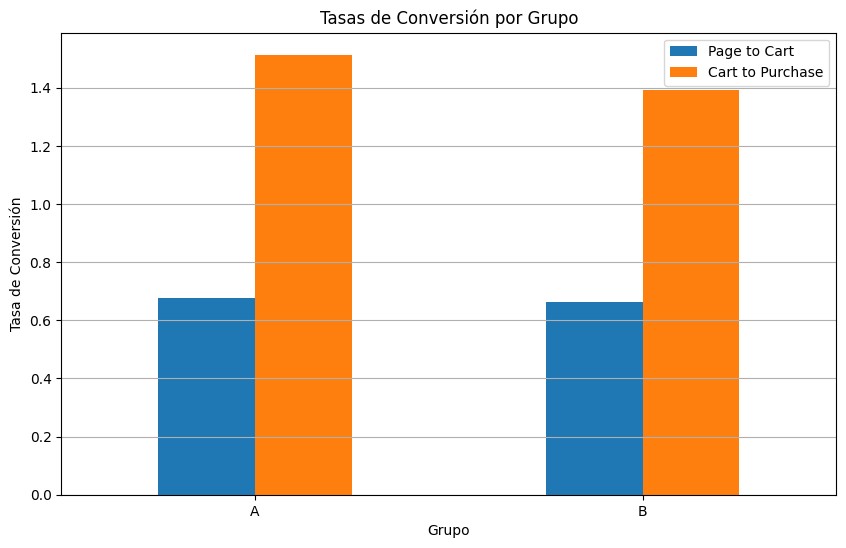

In [13]:
# Gr√°fico de tasas de conversi√≥n por etapa
conversion[['product_page_to_cart', 'cart_to_purchase']].plot(kind='bar', figsize=(10, 6))
plt.title("Tasas de Conversi√≥n por Grupo")
plt.ylabel("Tasa de Conversi√≥n")
plt.xlabel("Grupo")
plt.xticks(rotation=0)
plt.legend(["Page to Cart", "Cart to Purchase"])
plt.grid(axis='y')
plt.show()

**Observaciones**

- Tasa de conversi√≥n p√°gina a carrito (page_to_cart):
    - El Grupo B tiene una conversi√≥n ligeramente mayor (50.63%) que el Grupo A (48.47%).
    - Esto podr√≠a sugerir que los usuarios del Grupo B son m√°s propensos a a√±adir productos al carrito despu√©s de visitar la p√°gina del producto.

- Tasa de conversi√≥n carrito a compra (cart_to_purchase):
    - Ambas tasas son superiores al 100%. Esto podr√≠a indicar que algunos usuarios realizaron compras sin pasar expl√≠citamente por el evento "product_cart" o hubo usuarios que compraron m√∫ltiples veces.
    - El Grupo A tiene una tasa mayor (110.24%) que el Grupo B (105.79%), lo que indica una mejor eficacia en convertir carritos en compras.

### ¬øEl n√∫mero de eventos por usuario est√° distribuido equitativamente entre las muestras?


In [14]:
# Calcular n√∫mero de eventos por usuario en cada grupo
events_count = events_with_groups.groupby(['group', 'user_id'])['event_name'].count().reset_index()
events_distribution = events_count.groupby('group')['event_name'].describe()

print("\nDistribuci√≥n del n√∫mero de eventos por usuario:")
(events_distribution)



Distribuci√≥n del n√∫mero de eventos por usuario:


count      mean       std  min  25%  50%  75%  max
group                                                     
A      2235.0  3.015660  1.204374  1.0  2.0  3.0  4.0  7.0
B       700.0  2.697143  1.286996  1.0  2.0  3.0  3.0  8.0

**Observaciones** 

- Los usuarios del grupo experimental (B) realizan, en promedio, menos eventos que los del grupo control (3.35 vs. 3.88
- La desviaci√≥n est√°ndar es comparable entre los grupos (~1.9), lo que sugiere que la dispersi√≥n en el n√∫mero de eventos no var√≠a mucho entre ellos.
- Aunque el promedio de eventos es menor en el grupo B, tiene un usuario con 14 eventos (vs. 13 en A), indicando casos extremos en ambos grupos.

### ¬øHay usuarios que est√°n presentes en ambas muestras?


In [15]:
# Verificar usuarios duplicados entre grupos
user_group_counts = final_ab_participants.groupby('user_id')['group'].nunique()
users_in_both_groups = user_group_counts[user_group_counts > 1].count()

print("\nUsuarios presentes en ambas muestras:", users_in_both_groups)



Usuarios presentes en ambas muestras: 0


**Observaciones**

- No se localizaron usuarios presentes en ambas muestras.


### ¬øC√≥mo se distribuye el n√∫mero de eventos entre los d√≠as?


In [16]:
# Agregar una columna con solo la fecha de cada evento
events_with_groups['event_date'] = events_with_groups['event_dt'].dt.date

# Calcular el n√∫mero de eventos por d√≠a y grupo
daily_events = events_with_groups.groupby(['event_date', 'group'])['event_name'].count().reset_index()

print("\nDistribuci√≥n diaria de eventos:")
print(daily_events)



Distribuci√≥n diaria de eventos:
    event_date group  event_name
0   2020-12-07     A         122
1   2020-12-07     B         144
2   2020-12-08     A         135
3   2020-12-08     B          87
4   2020-12-09     A         142
5   2020-12-09     B         135
6   2020-12-10     A         127
7   2020-12-10     B          94
8   2020-12-11     A         140
9   2020-12-11     B          55
10  2020-12-12     A         126
11  2020-12-12     B          72
12  2020-12-13     A         119
13  2020-12-13     B          59
14  2020-12-14     A         383
15  2020-12-14     B         100
16  2020-12-15     A         392
17  2020-12-15     B          78
18  2020-12-16     A         377
19  2020-12-16     B         138
20  2020-12-17     A         452
21  2020-12-17     B         106
22  2020-12-18     A         467
23  2020-12-18     B         100
24  2020-12-19     A         544
25  2020-12-19     B         111
26  2020-12-20     A         547
27  2020-12-20     B         110
28  2020-

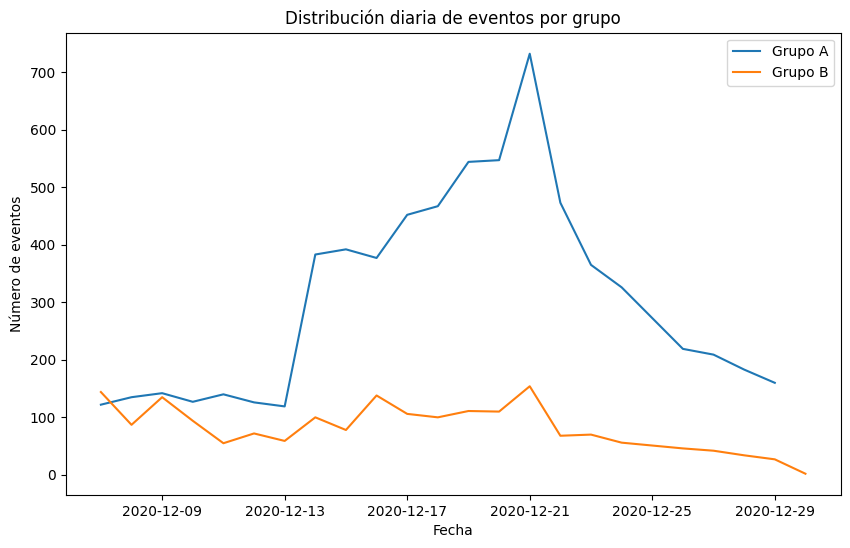

In [17]:
# Graficar la distribuci√≥n de eventos diarios
plt.figure(figsize=(10, 6))
for group in daily_events['group'].unique():
    group_data = daily_events[daily_events['group'] == group]
    plt.plot(group_data['event_date'], group_data['event_name'], label=f"Grupo {group}")

plt.title("Distribuci√≥n diaria de eventos por grupo")
plt.xlabel("Fecha")
plt.ylabel("N√∫mero de eventos")
plt.legend()
plt.show()

**Observaciones**

- El grupo A tiene consistentemente m√°s eventos diarios que el grupo B, lo cual es esperado dado que el grupo A cuenta con un mayor n√∫mero de usuarios.
- Desde el inicio (7 de diciembre) hasta el 21 de diciembre, ambos grupos muestran una tendencia ascendente en el n√∫mero de eventos diarios. Esto coincide con el per√≠odo en que se permit√≠a la inscripci√≥n de nuevos usuarios en la prueba.

### ¬øHay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [18]:
# Verificar fechas fuera del rango
out_of_range_users = final_ab_new_users[(final_ab_new_users['first_date'] < '2020-12-07') | (final_ab_new_users['first_date'] > '2020-12-21')]
out_of_range_events = final_ab_events[(final_ab_events['event_dt'] < '2020-12-07') | (final_ab_events['event_dt'] > '2021-01-01')]

print("\nUsuarios fuera del rango de fechas:", len(out_of_range_users))
print("Eventos fuera del rango de fechas:", len(out_of_range_events))

# Verificar dominancia de regiones o dispositivos
region_distribution = final_ab_new_users['region'].value_counts(normalize=True)
device_distribution = final_ab_new_users['device'].value_counts(normalize=True)

print("\nDistribuci√≥n de regiones:")
print(region_distribution)
print("\nDistribuci√≥n de dispositivos:")
print(device_distribution)



Usuarios fuera del rango de fechas: 0
Eventos fuera del rango de fechas: 0

Distribuci√≥n de regiones:
region
EU    1.0
Name: proportion, dtype: float64

Distribuci√≥n de dispositivos:
device
Android    0.444712
PC         0.254396
iPhone     0.202427
Mac        0.098465
Name: proportion, dtype: float64


**Observaciones**

- No se encontraron usuarios ni eventos fuera del rango de fechas.
- Los usuarios de la prueba se encuentran en la regi√≥n asignada (EU).
- Me parece interesante notificar que el 44.47% de los usuarios accedieron al sitio web por medio de un dispositivo Android, lo cual podr√≠a ser relevante para que proximas campa√±as pudieran estar optimizadas y dirigidas a este tipo de usuarios.

## Evaluar los resultados de la prueba A/B

### ¬øQu√© puedes decir sobre los resultados de la prueba A/B?


In [19]:
# Datos para evaluar la prueba A/B
product_page_A, product_page_B = 1632, 478
product_cart_A, product_cart_B = 791, 242
purchase_A, purchase_B = 872, 256

n_A, n_B = 2235, 700  # Total de usuarios √∫nicos en cada grupo

# Tasas de conversi√≥n en cada etapa
conversion_A = {
    "product_page": product_page_A / n_A,
    "product_cart": product_cart_A / product_page_A,
    "purchase": purchase_A / product_cart_A,
}

conversion_B = {
    "product_page": product_page_B / n_B,
    "product_cart": product_cart_B / product_page_B,
    "purchase": purchase_B / product_cart_B,
}

# Cambios relativos en cada etapa
relative_changes = {
    stage: ((conversion_B[stage] - conversion_A[stage]) / conversion_A[stage]) * 100
    for stage in conversion_A
}

# Evaluar si los cambios alcanzan el 10%
for stage, change in relative_changes.items():
    if change >= 10:
        print(f"‚úÖ La etapa '{stage}' alcanz√≥ el objetivo de aumento del 10%. (Cambio: {change:.2f}%)")
    else:
        print(f"‚ùå La etapa '{stage}' NO alcanz√≥ el objetivo de aumento del 10%. (Cambio: {change:.2f}%)")



‚ùå La etapa 'product_page' NO alcanz√≥ el objetivo de aumento del 10%. (Cambio: -6.48%)
‚ùå La etapa 'product_cart' NO alcanz√≥ el objetivo de aumento del 10%. (Cambio: 4.46%)
‚ùå La etapa 'purchase' NO alcanz√≥ el objetivo de aumento del 10%. (Cambio: -4.04%)


**Observaciones**

- Como podemos observar, no se logr√≥ el objetivo de aumento del 10% de la tasa de conversi√≥n en ninguna de las etapas del embudo.


### Utiliza una prueba z para comprobar la diferencia estad√≠stica entre las proporciones.

Hip√≥tesis:

    H0: No hay diferencia en las proporciones de conversi√≥n entre los grupos A y B.
    H1: Hay una diferencia en las proporciones de conversi√≥n entre los grupos A y B.

In [20]:
# Datos iniciales (n√∫mero de usuarios √∫nicos por grupo y etapa del embudo)
# Grupo A (control)
users_A = 2235  # Total usuarios en el grupo A
events_A = {'product_page': 1632, 'product_cart': 791, 'purchase': 872}

# Grupo B (prueba)
users_B = 700  # Total usuarios en el grupo B
events_B = {'product_page': 478, 'product_cart': 242, 'purchase': 256}

# Nivel de significancia
alpha = 0.05

# Funci√≥n para calcular la prueba z
def z_test_proportions(success_A, total_A, success_B, total_B):
    # Proporciones de cada grupo
    p1 = success_A / total_A
    p2 = success_B / total_B

    # Proporci√≥n combinada
    p_combined = (success_A + success_B) / (total_A + total_B)

    # Error est√°ndar
    se = np.sqrt(p_combined * (1 - p_combined) * (1 / total_A + 1 / total_B))

    # Estad√≠stico z
    z = (p2 - p1) / se

    # p-value
    p_value = 1 - norm.cdf(z)  # Prueba unilateral

    return z, p_value, p1, p2

# Evaluar cada etapa del embudo
results = {}
for stage in events_A.keys():
    z, p_value, p1, p2 = z_test_proportions(
        events_A[stage], users_A, events_B[stage], users_B
    )
    results[stage] = {'z': z, 'p_value': p_value, 'p1': p1, 'p2': p2}

results

{'product_page': {'z': np.float64(-2.4315903533709204),
  'p_value': np.float64(0.9924836507925889),
  'p1': 0.7302013422818792,
  'p2': 0.6828571428571428},
 'product_cart': {'z': np.float64(-0.39644916580921685),
  'p_value': np.float64(0.6541131490545489),
  'p1': 0.35391498881431765,
  'p2': 0.3457142857142857},
 'purchase': {'z': np.float64(-1.1601136227010536),
  'p_value': np.float64(0.8769987257553529),
  'p1': 0.3901565995525727,
  'p2': 0.3657142857142857}}

**An√°lisis de los resultados de la prueba Z**

1. Etapa product_page (Usuarios que visitaron la p√°gina del producto)
    - Proporci√≥n Grupo A: 73.02%
    - Proporci√≥n Grupo B: 68.28%
    - Estad√≠stico Z: -2.43
    - p-value: 0.9925

‚úÖ Interpretaci√≥n:
El valor p es mucho mayor que 0.05, lo que indica que no hay una diferencia estad√≠sticamente significativa en la proporci√≥n de usuarios que visitaron la p√°gina del producto entre ambos grupos.




2. Etapa product_cart (Usuarios que a√±adieron un producto al carrito)

    - Proporci√≥n Grupo A: 35.39%
    - Proporci√≥n Grupo B: 34.57%
    - Estad√≠stico Z: -0.40
    - p-value: 0.6541

‚úÖ Interpretaci√≥n:
La diferencia entre grupos en esta etapa es m√≠nima y el valor p es mayor que 0.05, lo que indica que no hay evidencia estad√≠stica de que uno de los grupos tenga una tasa de adici√≥n al carrito significativamente mayor que el otro.

3. Etapa purchase (Usuarios que realizaron una compra)

    - Proporci√≥n Grupo A: 39.02%
    - Proporci√≥n Grupo B: 36.57%
    - Estad√≠stico Z: -1.16
    - p-value: 0.8770
    
‚úÖ Interpretaci√≥n:
A pesar de que la proporci√≥n en el grupo A es ligeramente mayor, el p-value indica que no hay una diferencia estad√≠sticamente significativa en la tasa de compra entre ambos grupos.

## Conclusiones del Test A/B

- Ninguna de las etapas del embudo muestra una diferencia significativa entre los grupos A y B.
- Aunque el grupo A tiene una ligera ventaja en cada etapa, esta diferencia no es lo suficientemente grande para ser considerada relevante desde el punto de vista estad√≠stico.
- No hay evidencia de que el nuevo sistema de recomendaci√≥n (Grupo B) tenga un impacto significativo en la conversi√≥n de usuarios a lo largo del embudo de compra.
- Si el objetivo era mejorar la conversi√≥n con el nuevo sistema, los resultados sugieren que no hubo una mejora sustancial y quiz√°s sea necesario evaluar otros factores o realizar ajustes en la estrategia antes de implementarlo definitivamente.

üëâ Recomendaci√≥n: Antes de implementar el nuevo sistema de recomendaci√≥n, ser√≠a √∫til realizar m√°s pruebas o analizar otros factores que podr√≠an influir en la conversi√≥n (dise√±o de la p√°gina, experiencia del usuario, precios, etc.) considerando que el n√∫mero previsto de participantes de la prueba fuera de 6 000 y no se logr√≥ este objetivo adem√°s de que la proporci√≥n de participantes entre los grupos A y B no fue equitativa.